# Long Short-Term Memory (LSTM) for rainfall-runoff modelling

Recently, Kratzert et al. (2018a, 2018b) have shown the potential of LSTMs for rainfall-runoff modelling. Here, I'll show some example for setting up and training such a model. For single basin calibration (as done in this notebook) no GPU is required, and everything should run fine on a standard CPU (also rather slow, compared to a GPU).

In this example, we use the CAMELS data set (Newman et al. 2014) that provides us with approx. 35 years of daily meteorological forcings and discharge observations from 671 basins across the contiguos USA. As input to our model we use daily precipitation sum, daily min/max temperature as well as average solar radiation and vapor pressure. 


- Kratzert, F., Klotz, D., Brenner, C., Schulz, K., and Herrnegger, M.: Rainfall–runoff modelling using Long Short-Term Memory (LSTM) networks, Hydrol. Earth Syst. Sci., 22, 6005-6022, https://doi.org/10.5194/hess-22-6005-2018, 2018a. 

- Kratzert F., Klotz D., Herrnegger M., Hochreiter S.: A glimpse into the Unobserved: Runoff simulation for ungauged catchments with LSTMs, Workshop on Modeling and Decision-Making in the Spatiotemporal Domain, 32nd Conference on Neural Information Processing Systems (NeuRIPS 2018), Montréal, Canada. [https://openreview.net/forum?id=Bylhm72oKX](https://openreview.net/forum?id=Bylhm72oKX), 2018b.

- A. Newman; K. Sampson; M. P. Clark; A. Bock; R. J. Viger; D. Blodgett, 2014. A large-sample watershed-scale hydrometeorological dataset for the contiguous USA. Boulder, CO: UCAR/NCAR. https://dx.doi.org/10.5065/D6MW2F4D

Date: 29.05.2019<br/>
Created by: Frederik Kratzert (kratzert@ml.jku.at)

In [1]:
# Imports
from pathlib import Path
from typing import Tuple, List

import matplotlib.pyplot as plt
from numba import njit
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import tqdm

# Globals
CAMELS_ROOT = Path('/home/frederik/Data/CAMELS/')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # This line checks if GPU is available

## Data loading
### CAMELS specific data loader functions

Next we define two functions to load the meteorological forcings and the discharge for any specific basin from the camels data set. From the header of the forcing file we also extract the catchment area, to normalize the discharge (to mm/d)


In [2]:
def load_forcing(basin: str) -> Tuple[pd.DataFrame, int]:
    """Load the meteorological forcing data of a specific basin.

    :param basin: 8-digit code of basin as string.
    
    :return: pd.DataFrame containing the meteorological forcing data and the
        area of the basin as integer.
    """
    # root directory of meteorological forcings
    forcing_path = CAMELS_ROOT / 'basin_mean_forcing' / 'daymet'
    
    # get path of forcing file
    files = list(forcing_path.glob("**/*_forcing_leap.txt"))
    files = [f for f in files if basin == f.name[:8]]
    if len(files) == 0:
        raise RuntimeError(f'No forcing file file found for Basin {basin}')
    else:
        file_path = files[0]
    
    # read-in data and convert date to datetime index
    with file_path.open('r') as fp:
        df = pd.read_csv(fp, sep='\s+', header=3)
    dates = (df.Year.map(str) + "/" + df.Mnth.map(str) + "/"
             + df.Day.map(str))
    df.index = pd.to_datetime(dates, format="%Y/%m/%d")

    # load area from header
    with file_path.open('r') as fp:
        content = fp.readlines()
        area = int(content[2])

    return df, area


def load_discharge(basin: str, area: int) ->  pd.Series:
    """Load the discharge time series for a specific basin.

    :param basin: 8-digit code of basin as string.
    :param area: int, area of the catchment in square meters
    
    :return: A pd.Series containng the catchment normalized discharge.
    """
    # root directory of the streamflow data
    discharge_path = CAMELS_ROOT / 'usgs_streamflow'
    
    # get path of streamflow file file
    files = list(discharge_path.glob("**/*_streamflow_qc.txt"))
    files = [f for f in files if basin in f.name]
    if len(files) == 0:
        raise RuntimeError(f'No discharge file found for Basin {basin}')
    else:
        file_path = files[0]

    # read-in data and convert date to datetime index
    col_names = ['basin', 'Year', 'Mnth', 'Day', 'QObs', 'flag']
    with file_path.open('r') as fp:
        df = pd.read_csv(fp, sep='\s+', header=None, names=col_names)
    dates = (df.Year.map(str) + "/" + df.Mnth.map(str) + "/"
             + df.Day.map(str))
    df.index = pd.to_datetime(dates, format="%Y/%m/%d")

    # normalize discharge from cubic feed per second to mm per day
    df.QObs = 28316846.592 * df.QObs * 86400 / (area * 10 ** 6)

    return df.QObs

### Data reshaping for LSTM training
Next we need another utility function to reshape the data into an appropriate format for training LSTMs. These recurrent neural networks expect sequential input of the shape `(sequence length, number of features)`. We train our network to predict a single day of discharge from *n* days of precendent meteorological observations. For example, lets assume that _n_ = 365, then a single training sample should be of shape `(365, number of features)`, and since we use 5 input features the shape is `(365, 5)`.

However, when loaded from the files the entire data is stored in a matrix, where the number of rows correspond to the total number of days in the training set and the number of columns to the features. Thus we need to slide over this matrix and cut out small samples appropriate to our LSTM setting. To speed things up, we make use of the awesome Numba library here (the little @njit decorator JIT-compiles this function and dramatically increases the speed).

In [3]:
@njit
def reshape_data(x: np.ndarray, y: np.ndarray, seq_length: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Reshape matrix data into sample shape for LSTM training.

    :param x: Matrix containing input features column wise and time steps row wise
    :param y: Matrix containing the output feature.
    :param seq_length: Length of look back days for one day of prediction
    
    :return: Two np.ndarrays, the first of shape (samples, length of sequence,
        number of features), containing the input data for the LSTM. The second
        of shape (samples, 1) containing the expected output for each input
        sample.
    """
    num_samples, num_features = x.shape

    x_new = np.zeros((num_samples - seq_length + 1, seq_length, num_features))
    y_new = np.zeros((num_samples - seq_length + 1, 1))

    for i in range(0, x_new.shape[0]):
        x_new[i, :, :num_features] = x[i:i + seq_length, :]
        y_new[i, :] = y[i + seq_length - 1, 0]

    return x_new, y_new

### PyTorch data set
Now we wrap everything into a PyTorch Dataset. These are specific classes that can be used by PyTorchs DataLoader class for generating mini-batches (and do this in parallel in multiple threads). Such a data set class has to inherit from the PyTorch Dataset class and three functions have to be implemented

1. __init__(): The object initializing function.
2. __len__(): This function has to return the number of samples in the data set.
3. __getitem__(i): A function that returns sample `i` of the data set (sample + target value).

In [4]:
class CamelsTXT(Dataset):
    """Torch Dataset for basic use of data from the CAMELS data set.

    This data set provides meteorological observations and discharge of a given
    basin from the CAMELS data set.
    """

    def __init__(self, basin: str, seq_length: int=365,period: str=None,
                 dates: List=None, means: pd.Series=None, stds: pd.Series=None):
        """Initialize Dataset containing the data of a single basin.

        :param basin: 8-digit code of basin as string.
        :param seq_length: (optional) Length of the time window of
            meteorological input provided for one time step of prediction.
        :param period: (optional) One of ['train', 'eval']. None loads the 
            entire time series.
        :param dates: (optional) List of pd.DateTimes of the start and end date 
            of the discharge period that is used.
        :param means: (optional) Means of input and output features derived from
            the training period. Has to be provided for 'eval' period. Can be
            retrieved if calling .get_means() on the data set.
        :param stds: (optional) Stds of input and output features derived from
            the training period. Has to be provided for 'eval' period. Can be
            retrieved if calling .get_stds() on the data set.
        """
        self.basin = basin
        self.seq_length = seq_length
        self.period = period
        self.dates = dates
        self.means = means
        self.stds = stds

        # load data into memory
        self.x, self.y = self._load_data()

        # store number of samples as class attribute
        self.num_samples = self.x.shape[0]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx: int):
        return self.x[idx], self.y[idx]

    def _load_data(self):
        """Load input and output data from text files."""
        df, area = load_forcing(self.basin)
        df['QObs(mm/d)'] = load_discharge(self.basin, area)
        
        if self.dates is not None:
            # If meteorological observations exist before start date
            # use these as well. Similiar to hydrological warmup period.
            if self.dates[0] - pd.DateOffset(days=self.seq_length) > df.index[0]:
                start_date = self.dates[0] - pd.DateOffset(days=self.seq_length)
            else:
                start_date = self.dates[0]
            df = df[start_date:self.dates[1]]

        # if training period store means and stds
        if self.period == 'train':
            self.means = df.mean()
            self.stds = df.std()

        # extract input and output features from DataFrame
        x = np.array([df['prcp(mm/day)'].values,
                      df['srad(W/m2)'].values,
                      df['tmax(C)'].values,
                      df['tmin(C)'].values,
                      df['vp(Pa)'].values]).T
        y = np.array([df['QObs(mm/d)'].values]).T

        # normalize data, reshape for LSTM training and remove invalid samples
        x = self._local_normalization(x, variable='inputs')
        x, y = reshape_data(x, y, self.seq_length)

        if self.period == "train":
            # Delete all samples, where discharge is NaN
            if np.sum(np.isnan(y)) > 0:
                print(f"Deleted some records because of NaNs {self.basin}")
                x = np.delete(x, np.argwhere(np.isnan(y)), axis=0)
                y = np.delete(y, np.argwhere(np.isnan(y)), axis=0)
            
            # Deletes all records, where no discharge was measured (-999)
            x = np.delete(x, np.argwhere(y < 0)[:, 0], axis=0)
            y = np.delete(y, np.argwhere(y < 0)[:, 0], axis=0)
            
            # normalize discharge
            y = self._local_normalization(y, variable='output')

        # convert arrays to torch tensors
        x = torch.from_numpy(x.astype(np.float32))
        y = torch.from_numpy(y.astype(np.float32))

        return x, y

    def _local_normalization(self, feature: np.ndarray, variable: str) -> \
            np.ndarray:
        """Normalize input/output features with local mean/std.

        :param feature: Numpy array containing the feature(s) as matrix.
        :param variable: Either 'inputs' or 'output' showing which feature will
            be normalized
        :return: array containing the normalized feature
        """
        if variable == 'inputs':
            means = np.array([self.means['prcp(mm/day)'],
                              self.means['srad(W/m2)'],
                              self.means['tmax(C)'],
                              self.means['tmin(C)'],
                              self.means['vp(Pa)']])
            stds = np.array([self.stds['prcp(mm/day)'],
                             self.stds['srad(W/m2)'],
                             self.stds['tmax(C)'],
                             self.stds['tmin(C)'],
                             self.stds['vp(Pa)']])
            feature = (feature - means) / stds
        elif variable == 'output':
            feature = ((feature - self.means["QObs(mm/d)"]) /
                       self.stds["QObs(mm/d)"])
        else:
            raise RuntimeError(f"Unknown variable type {variable}")

        return feature

    def local_rescale(self, feature: np.ndarray, variable: str) -> \
            np.ndarray:
        """Rescale input/output features with local mean/std.

        :param feature: Numpy array containing the feature(s) as matrix.
        :param variable: Either 'inputs' or 'output' showing which feature will
            be normalized
        :return: array containing the normalized feature
        """
        if variable == 'inputs':
            means = np.array([self.means['prcp(mm/day)'],
                              self.means['srad(W/m2)'],
                              self.means['tmax(C)'],
                              self.means['tmin(C)'],
                              self.means['vp(Pa)']])
            stds = np.array([self.stds['prcp(mm/day)'],
                             self.stds['srad(W/m2)'],
                             self.stds['tmax(C)'],
                             self.stds['tmin(C)'],
                             self.stds['vp(Pa)']])
            feature = feature * stds + means
        elif variable == 'output':
            feature = (feature * self.stds["QObs(mm/d)"] +
                       self.means["QObs(mm/d)"])
        else:
            raise RuntimeError(f"Unknown variable type {variable}")

        return feature

    def get_means(self):
        return self.means

    def get_stds(self):
        return self.stds


## Build LSTM model

Here we implement a single layer LSTM with optional dropout in the final fully connected layer. Using PyTorch, we need to inherit from the `nn.Module` class and implement the `__init__()`, as well as a `forward()` function. To make things easy, we make use of the standard LSTM layer included in the PyTorch library.

The forward function implements the entire forward pass through the network, while the backward pass, used for updating the weights during training, is automatically derived from PyTorch autograd functionality.

In [5]:
class Model(nn.Module):
    """Implementation of a single layer LSTM network"""
    
    def __init__(self, hidden_size: int, dropout_rate: float=0.0):
        """Initialize model
        
        :param hidden_size: Number of hidden units/LSTM cells
        :param dropout_rate: Dropout rate of the last fully connected
            layer. Default 0.0
        """
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        
        # create required layer
        self.lstm = nn.LSTM(input_size=5, hidden_size=self.hidden_size, 
                            num_layers=1, bias=True, batch_first=True)
        self.dropout = nn.Dropout(p=self.dropout_rate)
        self.fc = nn.Linear(in_features=self.hidden_size, out_features=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the Network.
        
        :param x: Tensor of shape [batch size, seq length, num features]
            containing the input data for the LSTM network.
        
        :return: Tensor containing the network predictions
        """
        output, (h_n, c_n) = self.lstm(x)
        
        # perform prediction only at the end of the input sequence
        pred = self.fc(self.dropout(h_n[-1,:,:]))
        return pred

## Train utilities

Next we are implementing two functions for training and evaluating the model.

- `train_epoch()`: This function iterates one time over the entire training data set (called one epoch) and updates the weights of the network to minimize the loss function (we use the mean squared error here).
- `eval_model()`: To this function evaluates a data set and returns the predictions, as well as observations.

Furthermore we implement a function `calc_nse()` to calculate the Nash-Sutcliffe-Efficiency for our model

In [6]:
def train_epoch(model, optimizer, loader, loss_func, epoch):
    """Train model for a single epoch.

    :param model: A torch.nn.Module implementing the LSTM model
    :param optimizer: One of PyTorchs optimizer classes.
    :param loader: A PyTorch DataLoader, providing the trainings
        data in mini batches.
    :param loss_func: The loss function to minimize.
    :param epoch: The current epoch (int) used for the progress bar
    """
    # set model to train mode (important for dropout)
    model.train()
    pbar = tqdm.tqdm_notebook(loader)
    pbar.set_description(f"Epoch {epoch}")
    # request mini-batch of data from the loader
    for xs, ys in pbar:
        # delete previously stored gradients from the model
        optimizer.zero_grad()
        # push data to GPU (if available)
        xs, ys = xs.to(DEVICE), ys.to(DEVICE)
        # get model predictions
        y_hat = model(xs)
        # calculate loss
        loss = loss_func(y_hat, ys)
        # calculate gradients
        loss.backward()
        # update the weights
        optimizer.step()
        # write current loss in the progress bar
        pbar.set_postfix_str(f"Loss: {loss.item():.4f}")

        
def eval_model(model, loader) -> Tuple[torch.Tensor, torch.Tensor]:
    """Evaluate the model.

    :param model: A torch.nn.Module implementing the LSTM model
    :param loader: A PyTorch DataLoader, providing the data.
    
    :return: Two torch Tensors, containing the observations and 
        model predictions
    """
    # set model to eval mode (important for dropout)
    model.eval()
    obs = []
    preds = []
    # in inference mode, we don't need to store intermediate steps for
    # backprob
    with torch.no_grad():
        # request mini-batch of data from the loader
        for xs, ys in loader:
            # push data to GPU (if available)
            xs = xs.to(DEVICE)
            # get model predictions
            y_hat = model(xs)
            obs.append(ys)
            preds.append(y_hat)
            
    return torch.cat(obs), torch.cat(preds)
        
def calc_nse(obs: np.array, sim: np.array) -> float:
    """Calculate Nash-Sutcliff-Efficiency.

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :return: NSE value.
    """
    # only consider time steps, where observations are available
    sim = np.delete(sim, np.argwhere(obs < 0), axis=0)
    obs = np.delete(obs, np.argwhere(obs < 0), axis=0)

    # check for NaNs in observations
    sim = np.delete(sim, np.argwhere(np.isnan(obs)), axis=0)
    obs = np.delete(obs, np.argwhere(np.isnan(obs)), axis=0)

    denominator = np.sum((obs - np.mean(obs)) ** 2)
    numerator = np.sum((sim - obs) ** 2)
    nse_val = 1 - numerator / denominator

    return nse_val

## Prepare everything for training

Now that we have everything needed, we have to do the following steps:

- Specify a training, as well independent validation and test periods. For each of the three create a PyTorch data set and with these data sets PyTorch DataLoader. These DataLoader put single samples together to mini-batches that we use to train the network.
- Initialize the model
- Create a optimizer
- Define the loss function

In [7]:
basin = '01022500' # can be changed to any 8-digit basin id contained in the CAMELS data set
hidden_size = 10 # Number of LSTM cells
dropout_rate = 0.0 # Dropout rate of the final fully connected Layer [0.0, 1.0]
learning_rate = 1e-3 # Learning rate used to update the weights
sequence_length = 365 # Length of the meteorological record provided to the network

##############
# Data set up#
##############

# Training data
start_date = pd.to_datetime("1980-10-01", format="%Y-%m-%d")
end_date = pd.to_datetime("1995-09-30", format="%Y-%m-%d")
ds_train = CamelsTXT(basin, seq_length=sequence_length, period="train", dates=[start_date, end_date])
tr_loader = DataLoader(ds_train, batch_size=256, shuffle=True)

# Validation data. We use the feature means/stds of the training period for normalization
means = ds_train.get_means()
stds = ds_train.get_stds()
start_date = pd.to_datetime("1995-10-01", format="%Y-%m-%d")
end_date = pd.to_datetime("2000-09-30", format="%Y-%m-%d")
ds_val = CamelsTXT(basin, seq_length=sequence_length, period="eval", dates=[start_date, end_date],
                     means=means, stds=stds)
val_loader = DataLoader(ds_val, batch_size=2048, shuffle=False)

# Test data. We use the feature means/stds of the training period for normalization
start_date = pd.to_datetime("2000-10-01", format="%Y-%m-%d")
end_date = pd.to_datetime("2010-09-30", format="%Y-%m-%d")
ds_test = CamelsTXT(basin, seq_length=sequence_length, period="eval", dates=[start_date, end_date],
                     means=means, stds=stds)
test_loader = DataLoader(ds_test, batch_size=2048, shuffle=False)


#########################
# Model, Optimizer, Loss#
#########################

# Here we create our model, feel free 
model = Model(hidden_size=hidden_size, dropout_rate=dropout_rate).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()

## Train the model
Now we gonna train the model for some number of epochs. After each epoch we evaluate the model on the validation period and print out the NSE.

In [8]:
n_epochs = 20 # Number of training epochs

for i in range(n_epochs):
    train_epoch(model, optimizer, tr_loader, loss_func, i+1)
    obs, preds = eval_model(model, val_loader)
    preds = ds_val.local_rescale(preds.numpy(), variable='output')
    nse = calc_nse(obs.numpy(), preds)
    tqdm.tqdm.write(f"Validation NSE: {nse:.2f}")


Validation NSE: 0.01



Validation NSE: 0.10



Validation NSE: 0.19



Validation NSE: 0.26



Validation NSE: 0.35



Validation NSE: 0.44



Validation NSE: 0.49



Validation NSE: 0.52



Validation NSE: 0.54



Validation NSE: 0.55



Validation NSE: 0.57



Validation NSE: 0.57



Validation NSE: 0.58



Validation NSE: 0.59



Validation NSE: 0.60



Validation NSE: 0.60



Validation NSE: 0.61



Validation NSE: 0.62



Validation NSE: 0.62



Validation NSE: 0.63


## Evaluate independent test set
Finally, we can can evaluate our model on the unseen test data, calculate the NSE and plot some observations vs predictions

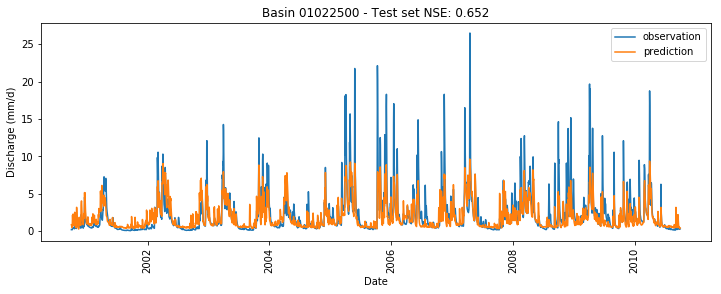

In [10]:
# Evaluate on test set
obs, preds = eval_model(model, test_loader)
preds = ds_val.local_rescale(preds.numpy(), variable='output')
obs = obs.numpy()
nse = calc_nse(obs, preds)

# Plot results
start_date = ds_test.dates[0]
end_date = ds_test.dates[1] + pd.DateOffset(days=1)
date_range = pd.date_range(start_date, end_date)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(date_range, obs, label="observation")
ax.plot(date_range, preds, label="prediction")
ax.legend()
ax.set_title(f"Basin {basin} - Test set NSE: {nse:.3f}")
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("Date")
_ = ax.set_ylabel("Discharge (mm/d)")

Congratulations, you have trained a LSTM. Although results for single basin calibration might not look superior to traditional hydrological models don't forget that this model had to learn every hydrological process from scratch. Also note that, due to computational contraints of the Pangeo servers, we trained very small LSTM networks. However, while getting the overall dynamics farely well, we can see that the LSTM (as most hydrological models) has problems with peak flows and is mostly underestimating them. 

I hope you are able with the code provided in this notebook to try LSTMs on your own data/problems. 